In [23]:
# We're going to start off in a jupyter notebook and slowly move this into a widget... for visualization with tests and stuff
#%matplotlib 
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from functools import reduce
from operator import concat
import glob

import pandas as pd

import seaborn as sns
sns.set_theme()

In [24]:

def find_walks_with_type(ID,walktype):
    loc = "/N/project/berkeley_walking/BerkeleyData/berkeley_json/"
    filesearch = f'{loc}s{str(ID)}*{walktype}*.json'
    files = glob.glob(filesearch)
    walks = [int(file.split('/')[-1].split('_')[1]) for file in files]
    if ID == 6 and walktype == 'pavement':
         walks = [2]
    walkNum = walks
    return walkNum


def load_data(ID,walkNum):

    Data = []
    footholds = []
    gazeGround = []
    for x in walkNum:
        loc = '/N/project/berkeley_walking/BerkeleyData/berkeley_pupilShadowMesh'
        data = sio.loadmat(f'{loc}/s{str(ID)}_{x}_pupilShadowMesh.mat')
        Data.append(data)    
        marker,skeleton,fholds,gGround = data['markerNames'], data['shadow'], data['step_plantfoot_xyz'],data['gazeXYZ']
        footholds.append(fholds)
        gazeGround.append(gGround)
        hips = np.squeeze(skeleton[:,1,:])
    return footholds, gazeGround, Data




def distances_closest_current(footholds,gazeGround):

    current_foothold = []
    closest_foothold= []
    distances = []
    for x,y in zip(footholds,gazeGround):
        frame_edges = np.append(np.append(1,x[:,0]),y.shape[0]+1)
        frames_per_foothold = np.diff(frame_edges)
        current = np.array(reduce(concat,[int(ff)*[ee] for ee,ff in enumerate(frames_per_foothold)]))
        current_foothold.append(current)

        d = cdist(y,x[:,2:])
        distances.append(d)

        closest= np.argmin(d,axis=1)+1
        closest_foothold.append(closest)

    return distances, closest_foothold, current_foothold




def find_rel_foothold_fixation(distances, closest_foothold, current_foothold):

    rel_foothold_fixation = []
    for x,y,z in zip (distances, closest_foothold, current_foothold):
            distances_min= np.min(x, axis = 1)
        
            rff = np.where(distances_min > 0.4, np.nan, y-z)
            rel_foothold_fixation.append(rff)
        
    rel_foothold_fixation = np.hstack(rel_foothold_fixation)
    five_steps = [x for x in rel_foothold_fixation if np.abs(x) < 6 and np.abs(x) > 0]
    return rel_foothold_fixation,five_steps

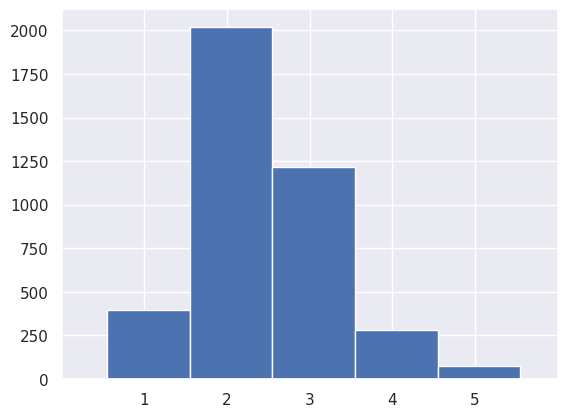

In [25]:
walkNum = find_walks_with_type(3,'rock')
footholds,gazeGround,Data = load_data(3,walkNum)
distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
plt.hist(steps, bins= np.arange(np.nanmin(steps)-.95,
               np.nanmax(steps)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.show()


In [26]:
#pooling the relative foothold fixations in each subject for each walk type


rel_foothold_fixation_rock = []
rock_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'rock')
    footholds,gazeGround,Data = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_rock.append(rel_foothold_fixation)
    rock_steps.append(steps)


rel_foothold_fixation_medium = []
medium_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'medium')
    footholds,gazeGround,Data = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_medium.append(rel_foothold_fixation)
    medium_steps.append(steps)


rel_foothold_fixation_flat = []
flat_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'flat')
    footholds,gazeGround,Data = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_flat.append(rel_foothold_fixation)
    flat_steps.append(steps)

rel_foothold_fixation_pavement = []
pavement_steps = []
for x in range(3,11):
    
    walkNum = find_walks_with_type(x,'pavement')
    footholds,gazeGround,Data = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rel_foothold_fixation,steps = find_rel_foothold_fixation(distances, closest_foothold, current_foothold)
    rel_foothold_fixation_pavement.append(rel_foothold_fixation)
    pavement_steps.append(steps)


In [27]:
def plot_par(rows,cols,n,steps):
    plt.subplot(rows,cols,n)
    plt.hist(steps[i], bins= np.arange(np.nanmin(steps[i])-.95,
               np.nanmax(steps[i])+ .95,1), align = 'right', rwidth = 1.88)
    plt.xlim(0,6)
    plt.xticks(np.arange(1,6,1))
    


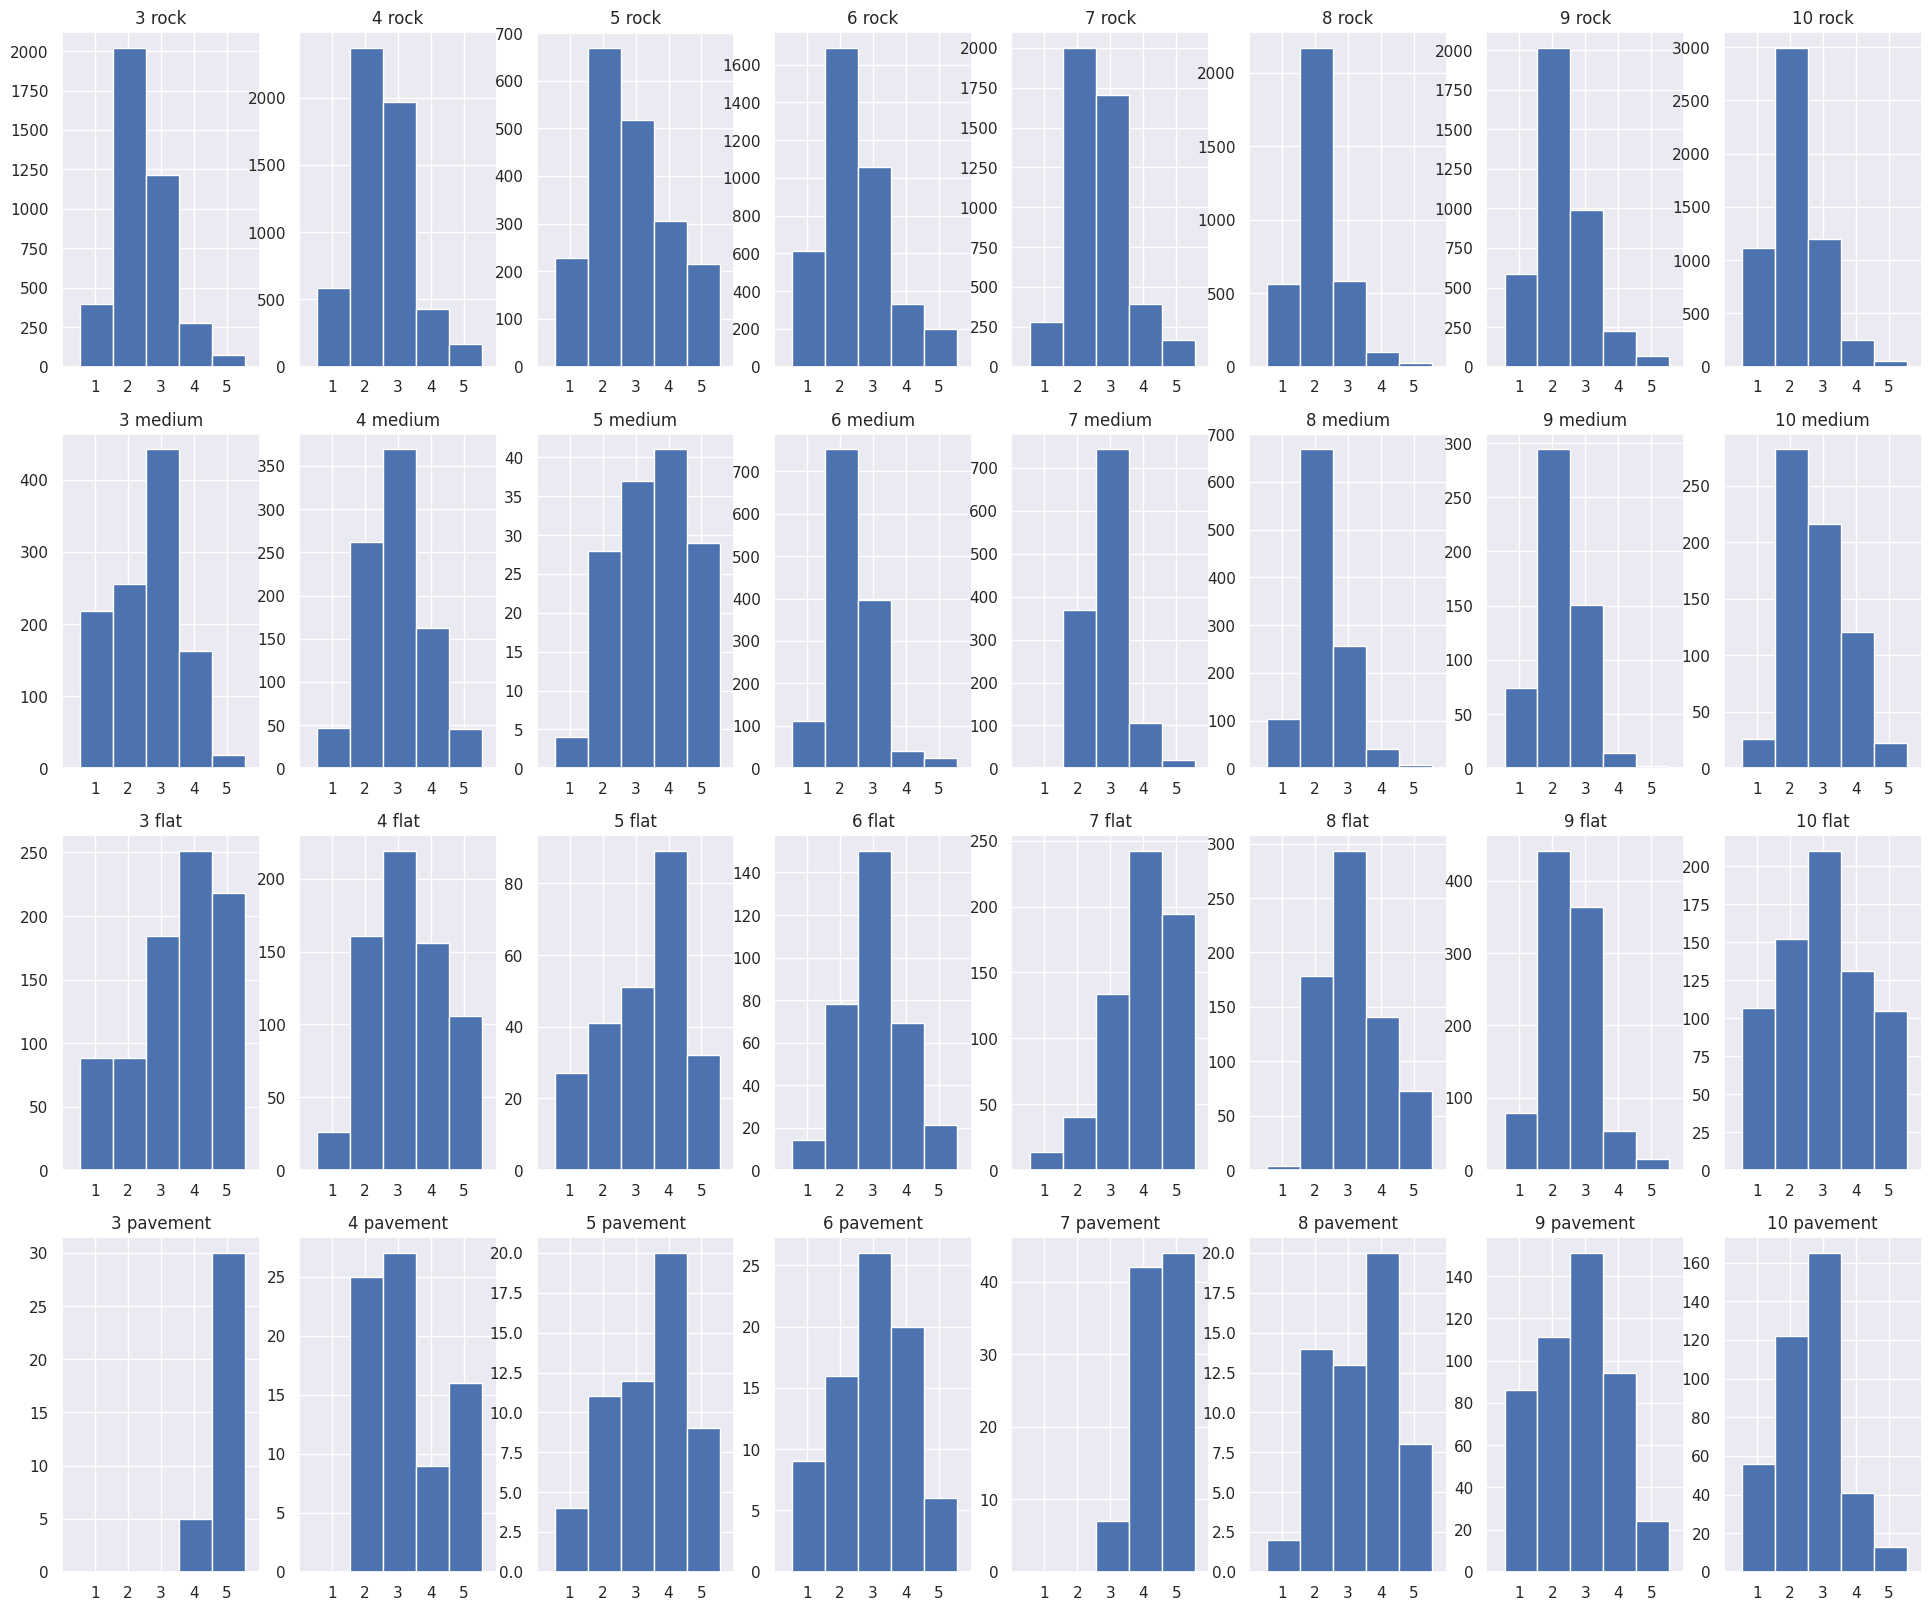

In [28]:
plt.figure(figsize=(24,20))

s = 2
for i in range(len(rock_steps)):
    n = i +1
    s +=1
    plot_par(4,8,n,rock_steps)
    plt.title(f'{s} rock')

s = 2   
n = 8
for i in range(len(medium_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,medium_steps)
    plt.title(f'{s} medium')


s = 2
n = 16
for i in range(len(flat_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,flat_steps)
    plt.title(f'{s} flat')
    
s = 2
n = 24
for i in range(len(pavement_steps)):
    n += 1
    s +=1
    plot_par(4,8,n,pavement_steps)
    plt.title(f'{s} pavement')


plt.tight_layout

plt.show()

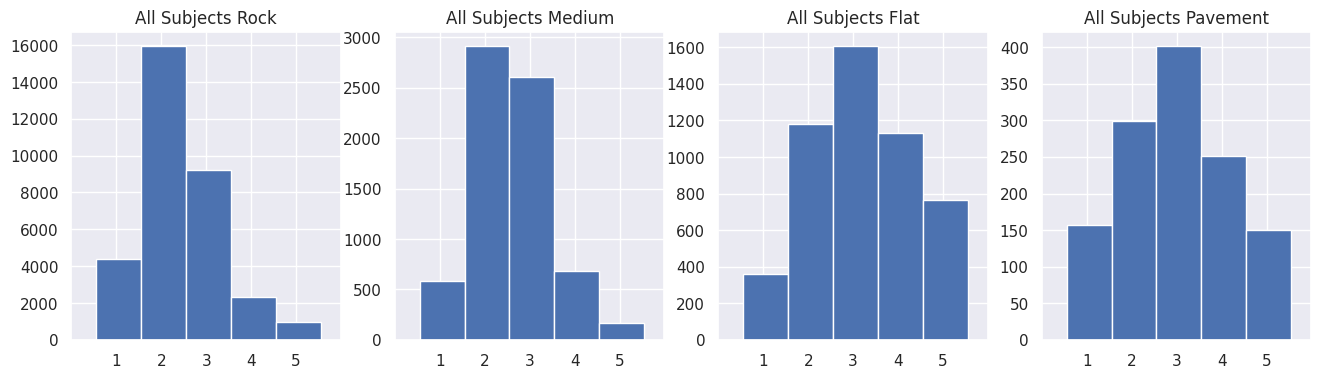

In [29]:
plt.figure(figsize=(16,4))


plt.subplot(1,4,1)
rel_foothold_fixation_allrock = np.hstack(rel_foothold_fixation_rock)
five_steps_rock = [x for x in rel_foothold_fixation_allrock if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_rock, bins= np.arange(np.nanmin(five_steps_rock)-.95,
               np.nanmax(five_steps_rock)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Rock')
    

plt.subplot(1,4,2)
rel_foothold_fixation_allmedium = np.hstack(rel_foothold_fixation_medium)
five_steps_medium = [x for x in rel_foothold_fixation_allmedium if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_medium, bins= np.arange(np.nanmin(five_steps_medium)-.95,
               np.nanmax(five_steps_medium)+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Medium')


plt.subplot(1,4,3)
rel_foothold_fixation_allflat = np.hstack(rel_foothold_fixation_flat)
five_steps_flat = [x for x in rel_foothold_fixation_allflat if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_flat , bins= np.arange(np.nanmin(five_steps_flat )-.95,
               np.nanmax(five_steps_flat )+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Flat')



plt.subplot(1,4,4)
rel_foothold_fixation_allpavement = np.hstack(rel_foothold_fixation_pavement)
five_steps_pavement = [x for x in rel_foothold_fixation_allpavement if np.abs(x) < 6 and np.abs(x) > 0]

plt.hist(five_steps_pavement , bins= np.arange(np.nanmin(five_steps_pavement )-.95,
               np.nanmax(five_steps_pavement )+ .95,1), align = 'right', rwidth = 1.88)
plt.xlim(0,6)
plt.xticks(np.arange(1,6,1))
plt.title('All Subjects Pavement')

plt.show()

In [30]:
import json

with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_13_rocks_allWalks.json", "r") as f:
    data = json.load(f)
with open("/N/project/berkeley_walking/BerkeleyData/berkeley_json/s6_13_rocks_allWalks.json", "w") as f:
    json.dump(data,f)

In [31]:
data.keys()

dict_keys(['ww', 'splitWalks_date', 'walkType', 'eyes', 'frames', 'sessionID', 'takeID', 'subID', 'shadowMarkerNames', 'processData_date', 'framerate', 'legLength', 'calibDist', 'px2mmScale', 'rVorCalibErr', 'comXYZ', 'isThisVORCalibrationData', 'rGazeGroundIntersection', 'rEyeballCenterXYZ', 'rGazeXYZ', 'headVecX_fr_xyz', 'headVecY_fr_xyz', 'headVecZ_fr_xyz', 'shadow_fr_mar_dim', 'rHeelXYZ', 'rToeXYZ', 'rFootXYZ', 'lHeelXYZ', 'lToeXYZ', 'lFootXYZ', 'hTopXYZ', 'headXYZ', 'hCenXYZ', 'steps_HS_TO_StanceLeg_XYZ', 'syncedUnixTime', 'gaze_norm_pos_x', 'gaze_norm_pos_y', 'worldFrameIndex', 'headGlobalQuat_wxyz', 'rEye_theta', 'rEye_phi', 'rEye_norm_pos_x', 'rEye_norm_pos_y', 'rEye_circle_3d_radius', 'rEye_blinks', 'sesh', 'rCorrAlignTheta', 'corrAlignTheta'])

In [32]:
def fixationList_index(distances, closest_foothold, current_foothold,Data):

    rff_fixationList= []
    for a,b,c,d in zip (distances, closest_foothold, current_foothold,Data):
        distances_min= np.min(a, axis = 1)
        
        rff = np.where(distances_min > 0.4, np.nan, b-c)
        rff = rff[d['fixationList'][:-1,0]]
        rff_fixationList.append(rff)

    return rff_fixationList

In [33]:
def create_matrix(walktype):
    nanmax = np.nanmax(walktype[0])
    nanmin = np.nanmin(walktype[0])

    fmax = 6
    count = np.zeros((fmax + 2, fmax +2 ))

    for r1, r2 in zip(walktype[0][:-2],walktype[0][1:]):
        if r1 > fmax or np.isnan(r1):
            r1 = fmax + 1
        if r2 > fmax or np.isnan(r2):
            r2 = fmax + 1
        count[int(r1),int(r2)] += 1
    count[0][1] = -1
    
    plt.imshow(count)
    plt.colorbar()
   

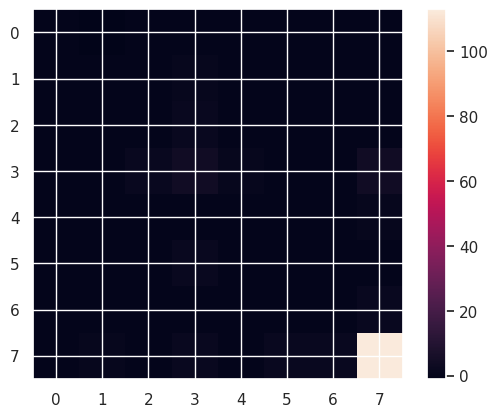

In [34]:
walkNum = find_walks_with_type(10,'pavement')
footholds,gazeGround,Data = load_data(10,walkNum)
distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
pavement = fixationList_index(distances, closest_foothold, current_foothold,Data)
create_matrix(pavement)
plt.title
plt.show()

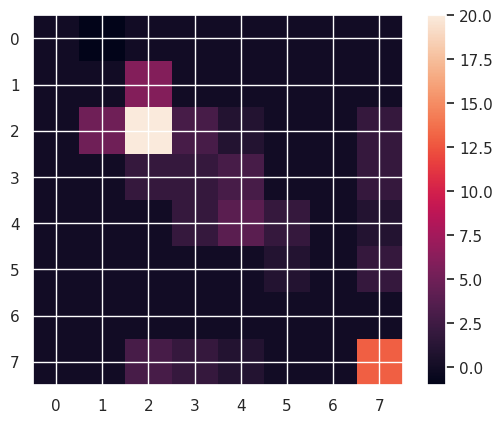

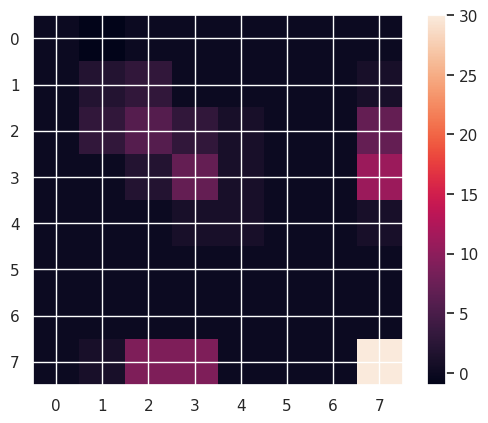

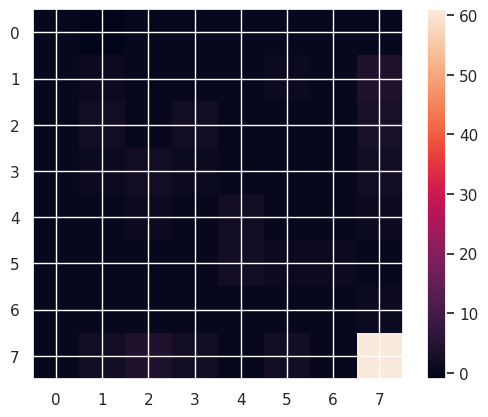

In [35]:
for x in range (3,6):
    
    walkNum = find_walks_with_type(x,'rock')
    footholds,gazeGround,Data = load_data(x,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rock = fixationList_index(distances, closest_foothold, current_foothold,Data)
    create_matrix(rock)
    plt.show()

In [36]:
def create_matrix(data, walktype, nrows, ncols, subjects, n):
    nanmax = np.nanmax(data[0])
    nanmin = np.nanmin(data[0])

    fmax = 6
    count = np.zeros((fmax + 2, fmax +2 ))

    for r1, r2 in zip(data[0][:-2],data[0][1:]):
        if r1 > fmax or np.isnan(r1) or r1 < 0:
            r1 = fmax + 1
        if r2 > fmax or np.isnan(r2) or r2 < 0:
            r2 = fmax + 1
        count[int(r1),int(r2)] += 1
    
    plt.subplot(nrows,ncols, n)
    plt.title(f'{subjects}  {walktype}')
    plt.imshow(count[0:7,:7])
    


/tmp/ipykernel_51224/725425018.py:2: RuntimeWarning: All-NaN slice encountered
  nanmax = np.nanmax(data[0])
/tmp/ipykernel_51224/725425018.py:3: RuntimeWarning: All-NaN slice encountered
  nanmin = np.nanmin(data[0])


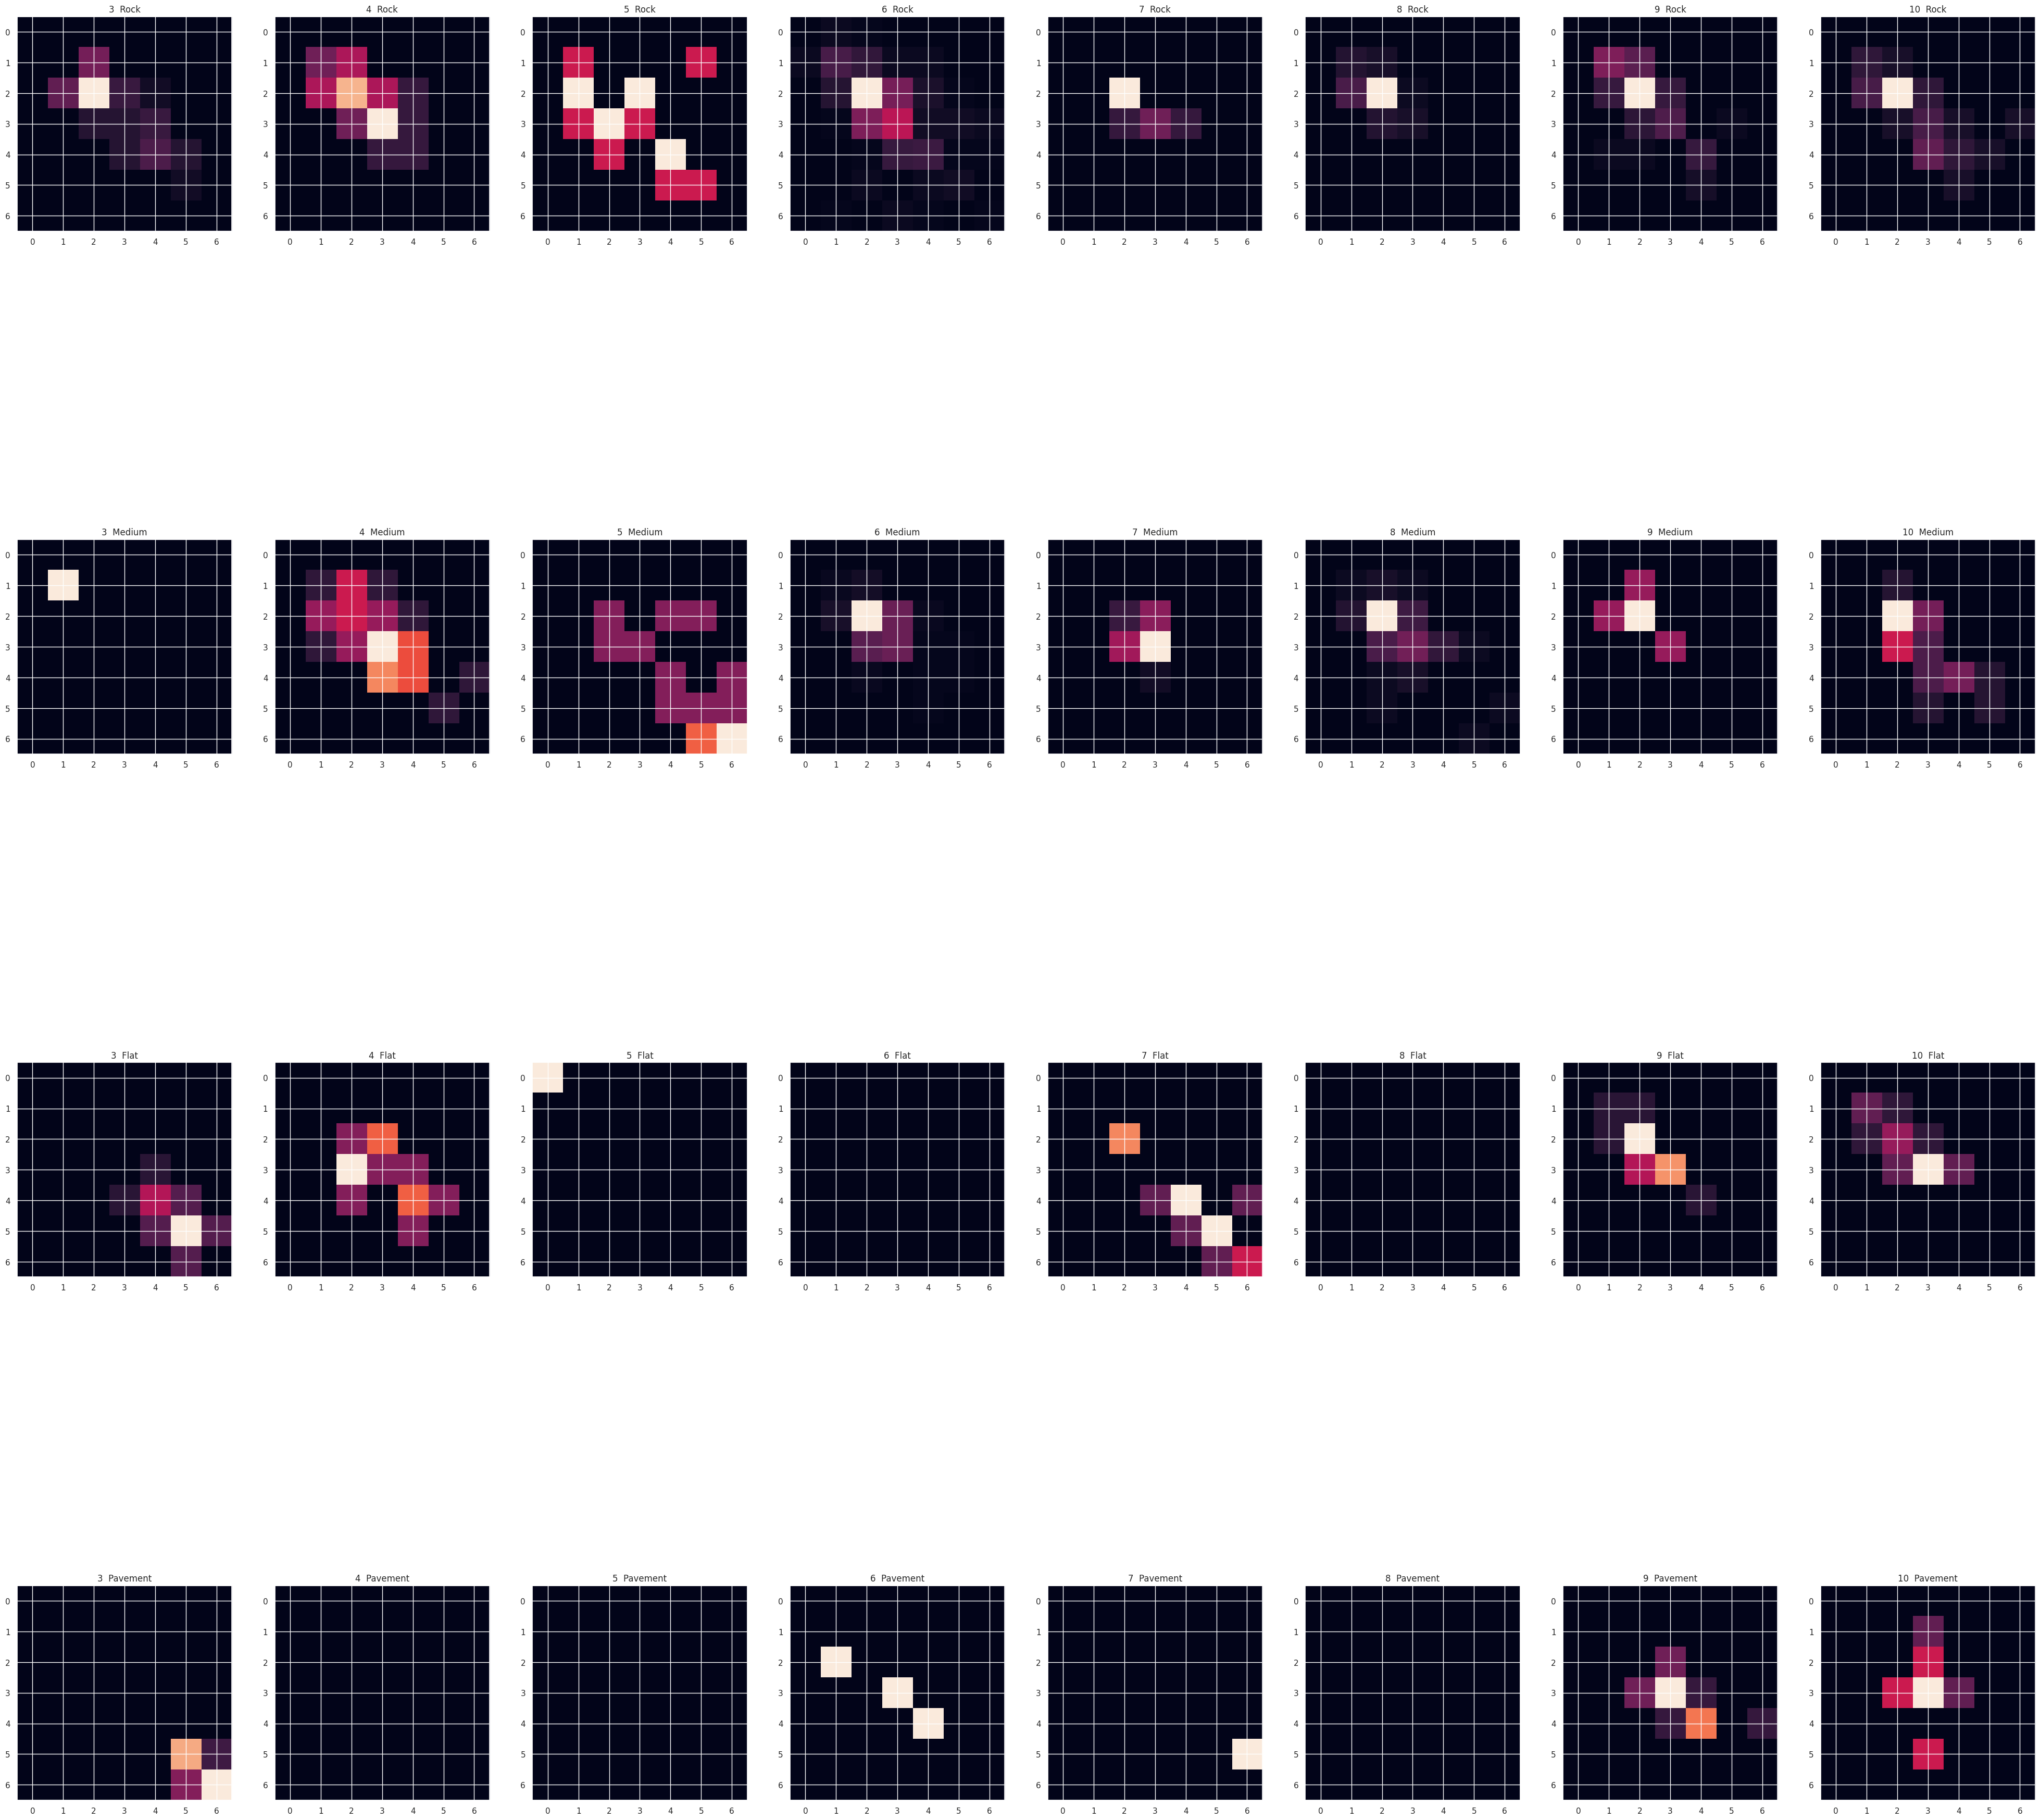

In [37]:
fig = plt.figure(figsize=(50,50))

for s, n in zip (range(3,11),range(1,9)):
    
    walkNum = find_walks_with_type(s,'rock')
    footholds,gazeGround,Data = load_data(s,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    rock = fixationList_index(distances, closest_foothold, current_foothold,Data)
    
    create_matrix(rock,'Rock',4,8,s,n)

for s, n in zip (range(3,11),range(9,17)):
    
    walkNum = find_walks_with_type(s,'medium')
    footholds,gazeGround,Data = load_data(s,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    medium = fixationList_index(distances, closest_foothold, current_foothold,Data)
    
    create_matrix(medium,'Medium',4,8,s,n)


for s, n in zip (range(3,11),range(17,25)):
    
    walkNum = find_walks_with_type(s,'flat')
    footholds,gazeGround,Data = load_data(s,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    flat = fixationList_index(distances, closest_foothold, current_foothold,Data)
    
    create_matrix(flat,'Flat',4,8,s,n)

for s, n in zip (range(3,11),range(25,33)):
    
    walkNum = find_walks_with_type(s,'pavement')
    footholds,gazeGround,Data = load_data(s,walkNum)
    distances, closest_foothold, current_foothold = distances_closest_current(footholds,gazeGround)
    pavement = fixationList_index(distances, closest_foothold, current_foothold,Data)
    
    create_matrix(pavement,'Pavement',4,8,s,n)

plt.tight_layout
plt.show()